## Proyecto Individual: Comparación de Pérdidas Térmicas (Cilindro vs. Esfera)

Comparación de pérdidas térmicas (en estado estacionario y estado transiente) entre dos cuerpos de igual volumen (esfera y cilindro circular recto) para distintas condiciones de intercambio térmico con el ambiente. Se utiliza el Método de Líneas en coordenadas cilíndricas y esféricas para resolver la ecuación de conducción de calor 1D (radial) sujeta a convección en la superficie externa.

In [56]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Primero, se definen los parámetros.

In [57]:
# Parámetros Físicos (Acero Inoxidable)
k = 16.2          # Conductividad térmica [W/m·K]
rho = 7990.0      # Densidad [kg/m3]
cp = 500.0        # Calor específico [J/kg·K]
h = 10.0          # Coeficiente convectivo [W/m2·K]
T_inf = 293.0     # Temperatura del aire ambiente [K] (20 °C)
Ti = 423.0        # Temperatura inicial del estanque [K] (150 °C)

In [58]:
# # Parámetros Geométricos (Mismo Volumen V) (Escala Industrial)
# V = 20.0 m³ y L/D = 1.5
V_referencia = 20.0
R_cilindro = (V_referencia / (3 * np.pi))**(1/3) # R ≈ 1.284 m
L_cilindro = 3 * R_cilindro
R_esfera = (3 * V_referencia / (4 * np.pi))**(1/3) # R_esfera ≈ 1.684 m
print(f" Radio Cilindro Industrial: {R_cilindro:.3f} m, Longitud: {L_cilindro:.3f} m")
print(f" Radio Esfera Industrial: {R_esfera:.3f} m")

 Radio Cilindro Industrial: 1.285 m, Longitud: 3.855 m
 Radio Esfera Industrial: 1.684 m


#### Parte 1.  Definición de Funciones (Método de Líneas)

Ambas implementan CB1 y CB2. 

Para el cilindro: 

In [59]:
def dTdt_cilindro(t, T, k, rho, cp, h, T_inf, ro, N):
    
    ri = 0.0
    dr = (ro - ri) / (N - 1)
    r = np.linspace(ri, ro, N)
    alpha = k / (rho * cp)
    N_last = N - 1
    
    A = np.zeros((N, N))
    b = np.zeros(N)

    # Nodos interiores 
    for i in range(1, N - 1):
        r_i = r[i]

        A[i, i-1] = alpha * (1/dr**2 - 1/(2*r_i*dr)) 
        A[i, i]   = -2 * alpha / dr**2 
        A[i, i+1] = alpha * (1/dr**2 + 1/(2*r_i*dr)) 
        b[i] = 0
    
    # CB1 (i=0): Eje de Simetría 
    A[0, 0] = -4 * alpha / dr**2
    A[0, 1] = 4 * alpha / dr**2
    b[0] = 0

    # CB2 (i=N-1): Convección
    A[N_last, N_last - 1] = alpha / dr**2
    A[N_last, N_last] = -alpha / dr**2 - h / (rho * cp * dr)
    b[N_last] = h * T_inf / (rho * cp * dr)

    dT = A @ T + b

    return dT

Para la esfera: 

In [60]:
def dTdt_esfera(t, T, k, rho, cp, h, T_inf, ro, N):
    
    ri = 0.0 # Eje de simetría
    dr = (ro - ri) / (N - 1)
    r = np.linspace(ri, ro, N)
    alpha = k / (rho * cp)
    N_last = N - 1
    
    A = np.zeros((N, N))
    b = np.zeros(N)


    # Nodos interiores
    for i in range(1, N - 1):
        r_i = r[i]
        
        A[i, i-1] = alpha * (1/dr**2 - 1/(r_i*dr)) 
        A[i, i]   = -2 * alpha / dr**2 
        A[i, i+1] = alpha * (1/dr**2 + 1/(r_i*dr)) 
        
        b[i] = 0 

    # CB1 (i=0): Eje de Simetría 
    A[0, 0] = -6 * alpha / dr**2
    A[0, 1] = 6 * alpha / dr**2
    b[0] = 0 
    

    # CB2 (i=N-1): Convección 
    
    A[N_last, N_last - 1] = alpha / dr**2
    A[N_last, N_last] = -alpha / dr**2 - h / (rho * cp * dr)
    b[N_last] = h * T_inf / (rho * cp * dr)

    dT = A @ T + b
    return dT

#### Parte 2. Ejecución del Método de Líneas (solve_ivp)

Se resuelve el sistema de EDOs para ambas geometrías asegurando que la Esfera tenga el mismo volumen que el Cilindro.

In [61]:
N = 100                    # Número de nodos
t_span = (0, 1000000)       # Tiempo total de simulación [s] 

T0 = np.ones(N) * Ti
t_eval = np.linspace(t_span[0], t_span[1], 100)
N_last = N - 1

# 1. Solución para el Cilindro
sol_cil = solve_ivp( dTdt_cilindro, t_span, T0, t_eval=t_eval, method='BDF', max_step=100, args=(k, rho, cp, h, T_inf, R_cilindro, N) )
T_surf_cil = sol_cil.y[N_last, :]

# 2. Solución para la Esfera
sol_esf = solve_ivp(dTdt_esfera, t_span, T0, t_eval=t_eval, method='BDF', max_step=100, args=(k, rho, cp, h, T_inf, R_esfera, N) )
T_surf_esf = sol_esf.y[N_last, :]

#### Parte 3. Análisis y Gráficos Comparativos

**3.1 Condición Ambiental Definida**

Se calcula la tasa de pérdida de calor instantánea ($Q$) en la superficie de cada cuerpo para comparar la eficiencia térmica.

$$\text{Pérdida de Calor Instantánea } (Q) = A_{\text{superficie}} \cdot h \cdot (T_{\text{superficie}} - T_{\infty})$$

In [62]:
# Cálculo de Pérdidas Térmicas Instantáneas (Q_loss)

# 1. Cilindro: Área manto
A_cil= 2 * np.pi * R_cilindro * L_cilindro 
V_cil = np.pi * R_cilindro**2 * L_cilindro
Q_loss_cil = A_cil * h * (T_surf_cil - T_inf)

# 2. Esfera: Área superficial 
A_esf = 4 * np.pi * R_esfera**2 
V_esf = (4/3) * np.pi * R_esfera**3
Q_loss_esf = A_esf * h * (T_surf_esf - T_inf)

print(f" Área Cilindro: {A_cil:.2f} m, Área Esfera: {A_esf:.2f} m")
print(f" Vol Cilindro: {V_cil:.2f} m, Vol Esfera: {V_esf:.2f} m")

# El vector radial para el cilindro y la esfera son diferentes debido a sus radios distintos.
r_grilla_cil = np.linspace(0, R_cilindro, N)
r_grilla_esf = np.linspace(0, R_esfera, N)

 Área Cilindro: 31.13 m, Área Esfera: 35.63 m
 Vol Cilindro: 20.00 m, Vol Esfera: 20.00 m


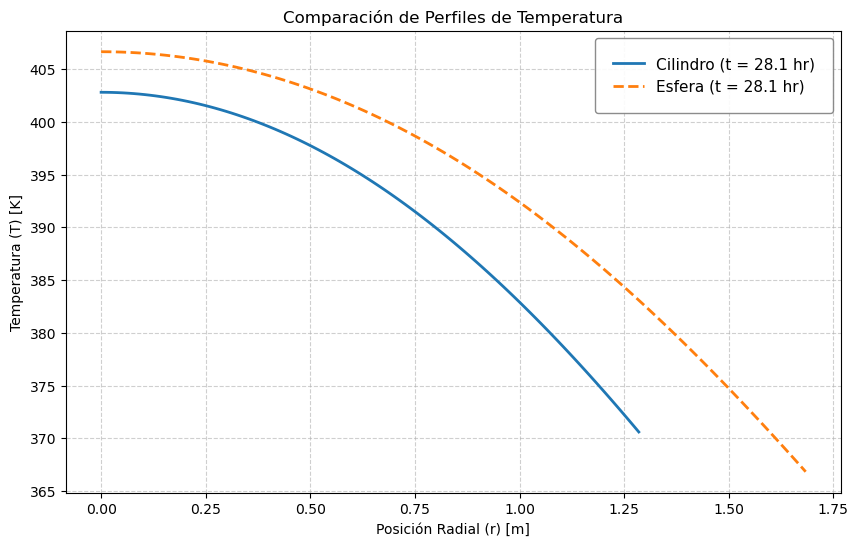

In [97]:

# --- Gráfico 1: Comparación del Perfil de Temperatura  ---
plt.figure(figsize=(10, 6))

# Seleccionamos un tiempo intermedio (e.g., t = 27.5 horas = 99000 s)
time_to_compare = 99000 # 27.5 horas
idx_compare = np.argmin(np.abs(sol_cil.t - time_to_compare))

# Perfiles de Temperatura en el tiempo seleccionado
T_profile_cil = sol_cil.y[:, idx_compare]
T_profile_esf = sol_esf.y[:, idx_compare]

plt.plot(r_grilla_cil, T_profile_cil, label=f'Cilindro (t = {sol_cil.t[idx_compare]/3600:.1f} hr)', linewidth=2)
plt.plot(r_grilla_esf, T_profile_esf, label=f'Esfera (t = {sol_esf.t[idx_compare]/3600:.1f} hr)', linewidth=2, linestyle='--')

plt.xlabel('Posición Radial (r) [m]')
plt.ylabel('Temperatura (T) [K]')
plt.title('Comparación de Perfiles de Temperatura')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='upper right', frameon=True, framealpha=0.9, facecolor='white', edgecolor='gray', borderpad=1.2)
plt.show()

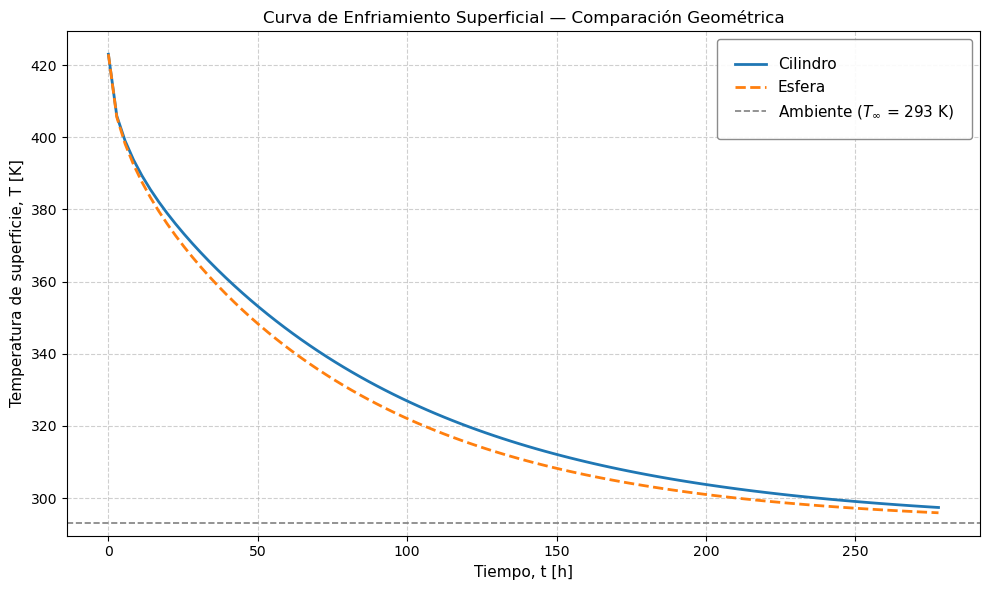

In [96]:
# --- GRÁFICO 2: Curva de enfriamiento de la superficie (Cilindro vs Esfera) ---

plt.figure(figsize=(10, 6))

# Curvas de temperatura en la superficie
plt.plot(sol_cil.t/3600, T_surf_cil, color='tab:blue', linewidth=2, label='Cilindro')
plt.plot(sol_esf.t/3600, T_surf_esf, color='tab:orange', linestyle='--', linewidth=2, label='Esfera')

# Línea de referencia del ambiente
plt.axhline(T_inf, color='gray', linestyle='--', linewidth=1.2, label=r'Ambiente ($T_{\infty}$ = 293 K)')

# Etiquetas y estilo
plt.xlabel('Tiempo, t [h]', fontsize=11)
plt.ylabel('Temperatura de superficie, T [K]', fontsize=11)
plt.title('Curva de Enfriamiento Superficial — Comparación Geométrica', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='upper right', frameon=True, framealpha=0.9, facecolor='white', edgecolor='gray', borderpad=1.2)
plt.tight_layout()
plt.show()


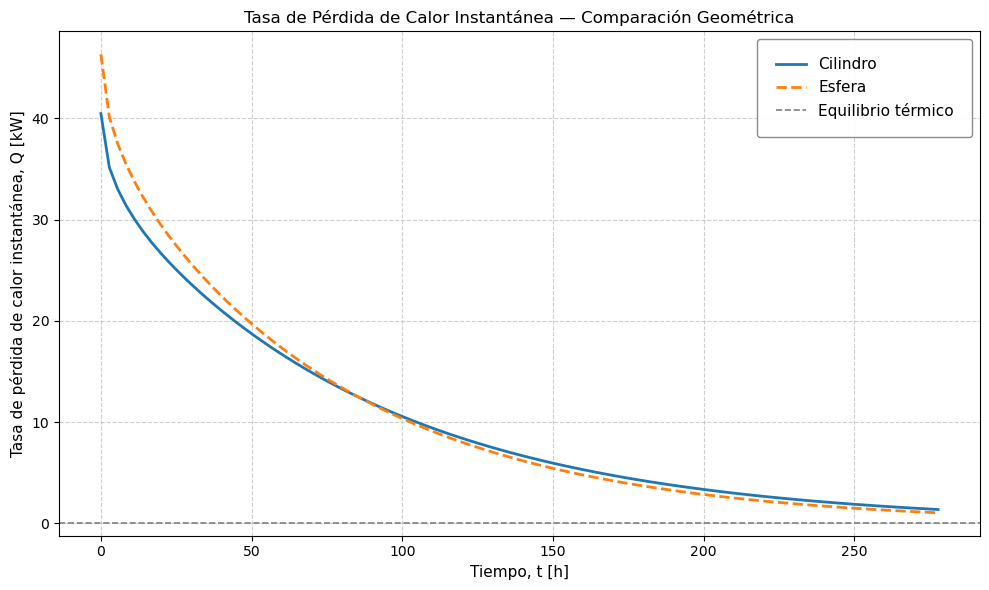

In [95]:
# --- GRÁFICO 3: Tasa de pérdida de calor instantánea (Q vs t) ---

plt.figure(figsize=(10, 6))

# Curvas de pérdida de calor (kW)
plt.plot(sol_cil.t/3600, Q_loss_cil/1000, color='tab:blue', linewidth=2, label='Cilindro')
plt.plot(sol_esf.t/3600, Q_loss_esf/1000, color='tab:orange', linestyle='--', linewidth=2, label='Esfera')

# Línea de referencia del equilibrio térmico (T_inf)
plt.axhline(0, color='gray', linestyle='--', linewidth=1.2, label='Equilibrio térmico')

# Etiquetas y formato visual
plt.xlabel('Tiempo, t [h]', fontsize=11)
plt.ylabel('Tasa de pérdida de calor instantánea, Q [kW]', fontsize=11)
plt.title('Tasa de Pérdida de Calor Instantánea — Comparación Geométrica', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='upper right', frameon=True, framealpha=0.9, facecolor='white', edgecolor='gray', borderpad=1.2)
plt.tight_layout()
plt.show()

**3.2 Variando Condiciones Ambientales**

In [ ]:
# GRAFICOS SEPARADOS POR CILINDRO Y ESFERA

# --- DEFINICIÓN DE ESCENARIOS AMBIENTALES ---
SCENARIOS = {
    'Base (Convección Natural)': {
        'h': 10.0,       # W/m²·K (Caso de referencia)
        'T_inf': 293.0   # K (20 °C)
    },
    'Convección Forzada Baja (h=25)': {
        'h': 25.0,       # W/m²·K (Viento moderado, alta pérdida)
        'T_inf': 293.0   # K (20 °C)
    },
    'Ambiente Frío (T_inf=0°C)': {
        'h': 10.0,       # W/m²·K (Convección natural)
        'T_inf': 273.15  # K (0 °C, Mayor impulsor térmico)
    }
}

all_results = {}

# Bucle para simular cada escenario para AMBOS CUERPOS
for name, params in SCENARIOS.items():
    
    # 1. Simulación para el CILINDRO
    sol_cil = solve_ivp(
        dTdt_cilindro, 
        t_span, 
        T0, 
        t_eval=t_eval,
        method='BDF',
        max_step=100.0,
        args=(k, rho, cp, params['h'], params['T_inf'], R_cilindro, N) 
    )
    
    # 2. Simulación para la ESFERA
    sol_esf = solve_ivp(
        dTdt_esfera, 
        t_span, 
        T0, 
        t_eval=t_eval,
        method='BDF',
        max_step=100.0,
        args=(k, rho, cp, params['h'], params['T_inf'], R_esfera, N) 
    )
        
    # Almacenamiento de resultados (T_surf y Q_loss)
    T_surf_cil = sol_cil.y[N_last, :]
    A_cil = 2 * np.pi * R_cilindro * L_cilindro 
    Q_loss_cil = A_cil * params['h'] * (T_surf_cil - params['T_inf'])
    
    T_surf_esf = sol_esf.y[N_last, :]
    A_esf = 4 * np.pi * R_esfera**2 
    Q_loss_esf = A_esf * params['h'] * (T_surf_esf - params['T_inf'])
    
    all_results[name] = {
        'Cilindro': {'Q_loss': Q_loss_cil, 'T_surf': T_surf_cil},
        'Esfera': {'Q_loss': Q_loss_esf, 'T_surf': T_surf_esf}
    }


print("Integración de todos los escenarios para ambas geometrías completada.")

Integración de todos los escenarios para ambas geometrías completada.


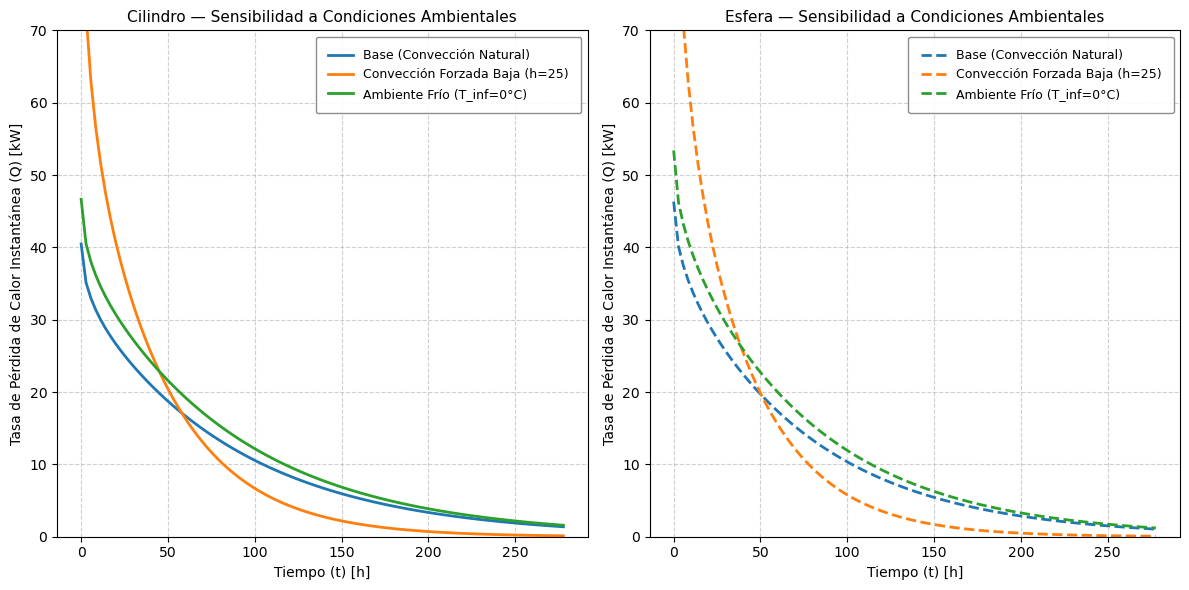

In [99]:
# --- Gráfico 4: Sensibilidad de Pérdida Q a las Condiciones Ambientales ---
# (Formato y estilo consistente con los gráficos anteriores)

plt.figure(figsize=(12, 6))

# Definimos los colores para mantener consistencia visual
colors = {
    'Base (Convección Natural)': 'tab:blue',
    'Convección Forzada Baja (h=25)': 'tab:orange',
    'Ambiente Frío (T_inf=0°C)': 'tab:green'
}

# --- Subplot 1: Cilindro ---
plt.subplot(1, 2, 1)
for name, res in all_results.items():
    plt.plot(
        sol_cil.t / 3600,
        res['Cilindro']['Q_loss'] / 1000,
        label=name,
        color=colors[name],
        linewidth=2
    )

plt.title('Cilindro — Sensibilidad a Condiciones Ambientales', fontsize=11)
plt.xlabel('Tiempo (t) [h]')
plt.ylabel('Tasa de Pérdida de Calor Instantánea (Q) [kW]')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=9, loc='upper right', frameon=True, framealpha=0.9, facecolor='white', edgecolor='gray', borderpad=1)
plt.ylim(0, 70)

# --- Subplot 2: Esfera ---
plt.subplot(1, 2, 2)
for name, res in all_results.items():
    plt.plot(
        sol_esf.t / 3600,
        res['Esfera']['Q_loss'] / 1000,
        label=name,
        color=colors[name],
        linewidth=2,
        linestyle='--'  # Mantiene el contraste visual con el cilindro
    )

plt.title('Esfera — Sensibilidad a Condiciones Ambientales', fontsize=11)
plt.xlabel('Tiempo (t) [h]')
plt.ylabel('Tasa de Pérdida de Calor Instantánea (Q) [kW]')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=9, loc='upper right', frameon=True, framealpha=0.9, facecolor='white', edgecolor='gray', borderpad=1)
plt.ylim(0, 70)

# --- Ajuste de formato general ---
plt.tight_layout()
plt.show()


Variación de Condiciones Ambientales, Cilindro y Esfera en el mismo gráfico. 

Integración completa para todos los escenarios y geometrías.


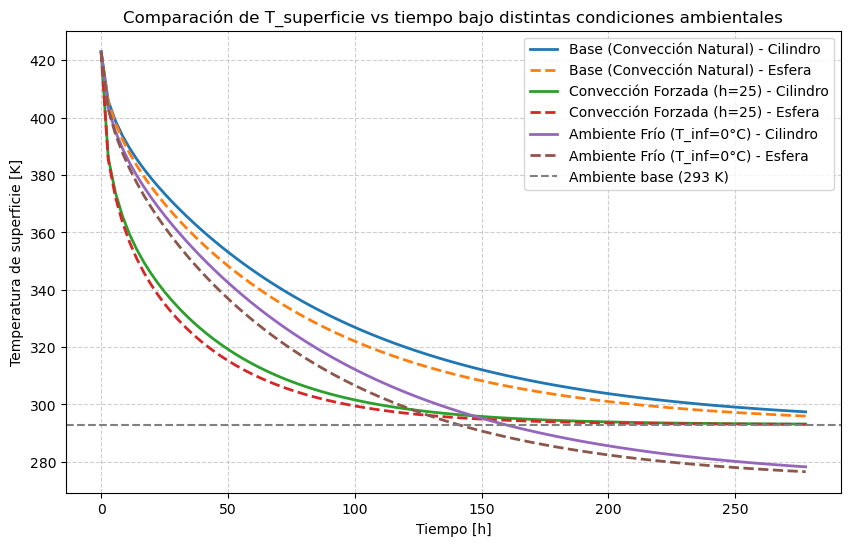

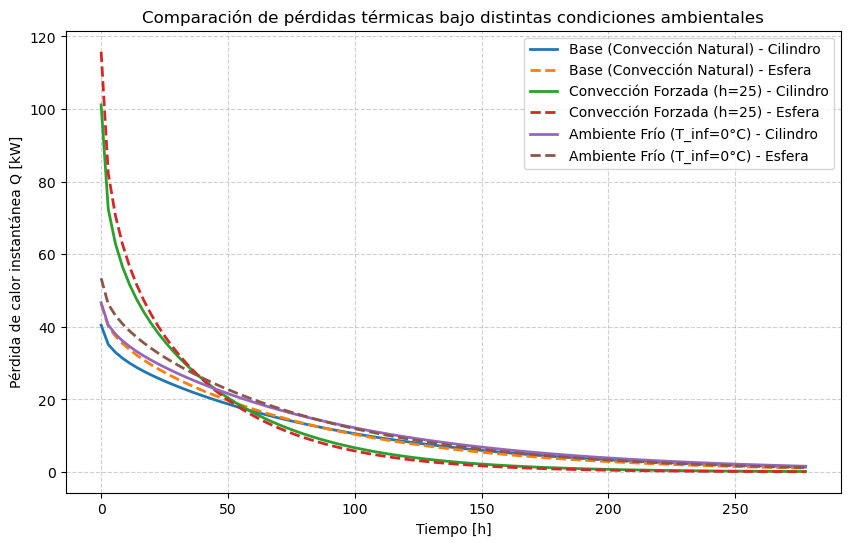

In [ ]:
# GRAFICOS JUNTOS POR CILINDRO Y ESFERA

# ---- ESCENARIOS AMBIENTALES ----
SCENARIOS = {
    "Base (Convección Natural)": {"h": 10.0, "T_inf": 293.0},      # Aire tranquilo, 20°C
    "Convección Forzada (h=25)": {"h": 25.0, "T_inf": 293.0},      # Viento moderado
    "Ambiente Frío (T_inf=0°C)": {"h": 10.0, "T_inf": 273.15},     # Aire más frío, 0°C
}

# Diccionario para guardar resultados
results = {}

for name, params in SCENARIOS.items():
    h_case = params["h"]
    T_inf_case = params["T_inf"]

    # ---- Solución para el Cilindro ----
    sol_cil = solve_ivp(
        dTdt_cilindro,
        t_span,
        T0,
        t_eval=t_eval,
        method="BDF",
        max_step=100.0,
        args=(k, rho, cp, h_case, T_inf_case, R_cilindro, N)
    )

    # ---- Solución para la Esfera ----
    sol_esf = solve_ivp(
        dTdt_esfera,
        t_span,
        T0,
        t_eval=t_eval,
        method="BDF",
        max_step=100.0,
        args=(k, rho, cp, h_case, T_inf_case, R_esfera, N)
    )

    # ---- Temperaturas de superficie ----
    Tsurf_cil = sol_cil.y[N - 1, :]
    Tsurf_esf = sol_esf.y[N - 1, :]

    # ---- Pérdida de calor instantánea ----
    A_cil = 2 * np.pi * R_cilindro * L_cilindro
    A_esf = 4 * np.pi * R_esfera**2

    Q_cil = A_cil * h_case * (Tsurf_cil - T_inf_case)
    Q_esf = A_esf * h_case * (Tsurf_esf - T_inf_case)

    # Guardamos resultados
    results[name] = {
        "T_cil": Tsurf_cil,
        "T_esf": Tsurf_esf,
        "Q_cil": Q_cil,
        "Q_esf": Q_esf,
        "T_inf": T_inf_case,
    }

print("Integración completa para todos los escenarios y geometrías.")

# ---- GRÁFICO 1: Evolución de temperatura superficial ----
plt.figure(figsize=(10, 6))
for name, res in results.items():
    plt.plot(sol_cil.t / 3600, res["T_cil"], label=f"{name} - Cilindro", linewidth=2)
    plt.plot(sol_esf.t / 3600, res["T_esf"], "--", label=f"{name} - Esfera", linewidth=2)
plt.axhline(293, color="gray", linestyle="--", label="Ambiente base (293 K)")
plt.xlabel("Tiempo [h]")
plt.ylabel("Temperatura de superficie [K]")
plt.title("Comparación de T_superficie vs tiempo bajo distintas condiciones ambientales")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# ---- GRÁFICO 2: Pérdida de calor instantánea ----
plt.figure(figsize=(10, 6))
for name, res in results.items():
    plt.plot(sol_cil.t / 3600, res["Q_cil"] / 1000, label=f"{name} - Cilindro", linewidth=2)
    plt.plot(sol_esf.t / 3600, res["Q_esf"] / 1000, "--", label=f"{name} - Esfera", linewidth=2)
plt.xlabel("Tiempo [h]")
plt.ylabel("Pérdida de calor instantánea Q [kW]")
plt.title("Comparación de pérdidas térmicas bajo distintas condiciones ambientales")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()